In [2]:
import netCDF4
import pathlib as path
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from fnmatch import fnmatch
from typing import Iterable
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import norm

### Load data files

In [6]:
vars_to_read = ['Time','GGALT','LATC','LONC', # 4-D Position
                'UIC','VIC','WIC',            # winds
                'ATX','PSXC','EWX','RHUM',           # other state params
                ] 

def find_flight_fnames(dir_path: str) -> list[str]:
    """
    find_flight_fnames just searches a directory for all *.nc files and returns a list of them.

    :param dir_path: a path to the directory containing flight netcdf files

    :return: Returns a list of flight netcdf files.
    """
    flight_paths=[]
    flight_fnames = sorted([fname for fname in os.listdir(dir_path) if fnmatch(fname, "*.nc")])
    for i in range(len(flight_fnames)):
        flight_paths.append(dir_path + '/' + flight_fnames[i])
    
    return flight_paths
    
def find_nc_fnames(dir_path: str) -> list[str]:
    """
    find_flight_fnames just searches a directory for all *.nc files and returns a list of them.
    
    :param dir_path: a path to the directory containing flight netcdf files
    
    :return: Returns a list of flight netcdf files.
    """
    nc_paths=[]
    nc_fnames = sorted([fname for fname in os.listdir(dir_path) if fnmatch(fname, "*.nc")])
    for i in range(len(nc_fnames)):
        nc_paths.append(dir_path + '/' + nc_fnames[i])
        
        nudg_path = [file for file in nc_paths if ".hs." in file]
        free_path = [file for file in nc_paths if ".h0." in file]
        # save dictionary with the paths for 
        model_paths = {'Free': free_path,'Nudg': nudg_path}
        
    return model_paths

def open_nc(paths: str) -> netCDF4._netCDF4.Dataset:
    """
    open_flight_nc simply checks to see if the file at the provided path string exists and opens it.

    :param file_path: A path string to a flight data file, e.g. "./test/test_flight.nc"

    :return: Returns xr.open_dataset object.
    """

    nc_path = path.Path(paths)
    if not nc_path.is_file():
        raise FileNotFoundError('testing excptions')

    return xr.open_dataset(paths)

def read_flight_nc_1hz(nc: xr.open_dataset, read_vars: list[str] = vars_to_read) -> pd.DataFrame:
    """
    read_flight_nc reads a set of variables into memory.

    NOTE: a low-rate, 1 Hz, flight data file is assumed

    :param nc: netCDF4._netCDF4.Dataset object opened by open_flight_nc.
    :param read_vars: An optional list of strings of variable names to be read into memory. A default
                      list, vars_to_read, is specified above. Passing in a similar list will read in those variables
                      instead.

    :return: Returns a pandas data frame.
    """

    data = [] # an empty list to accumulate Dataframes of each variable to be read in
    for var in read_vars:
        try:
            if var == "Time":
                # time is provided every second, so need to calculate 25 Hz times efficiently
                # tunits = getattr(nc[var],'units')
                # df = xr.open_dataset(nc)
                time = np.array(nc.Time)
                data.append(pd.DataFrame({var: time}))
                # dt_list = sfm_to_datetime(time, tunits)
                # data.append(pd.DataFrame({'datetime': time}))
            else:
                output = nc[var][:]
                data.append(pd.DataFrame({var: output}))
        except Exception as e:
            print(f"Issue reading {var}: {e}")
            pass
    

    # concatenate the list of dataframes into a single dataframe and return it
    return pd.concat(data, axis=1, ignore_index=False)

In [62]:
def filt_model_dims(cesm_dat: xr.open_dataset,df: pd.DataFrame):
    """
    Returns the lat, lon, and time from the nudged file that occur during specific research flight
    
    This function maps aircraft data onto a predefined grid based on CESM data
    
    NOTE: A low-rate, 1 Hz, flight data file is assumed.
    
    :param gv_dat: A dataset object containing aircraft data (e.g., LATC, LONC, U, V, T).
    :param cesm_dat: A dataset object containing CESM data (e.g., lat, lon, lev).
    
    :return: A dictionary containing latitude (lats), longitude (lons), and time 
             for grid cells where data is present.
    """
    da = xr.DataArray(cesm_dat.time, dims="time")
    cesm_times = pd.to_datetime([pd.Timestamp(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
                        for dt in da.values])
    
    aircraft_times = df.Time
    
    matching_indices = cesm_times.isin(aircraft_times)
    # Assuming cesm_dat.lat and matching_indices are already defined
    # Create a boolean mask for lat values you want to exclude
    lat = np.array(cesm_dat.lat[matching_indices])  # This gives the full lat array
    lon = np.array(cesm_dat.lon[matching_indices])  # This gives the full lat array
    time = np.array(cesm_times[matching_indices])  # This gives the full lat array
    
    # Define a threshold for what is considered a "high" difference
    lat_threshold = 1  # You can adjust this value
    lon_threshold = 1
    
    # Find the indices where the difference exceeds the threshold
    outlier_indices_lat = np.where(np.abs(np.diff(lat)) > lat_threshold)[0]
    outlier_indices_lon = np.where(np.abs(np.diff(lon)) > lon_threshold)[0]
    
    outliers = np.array([])
    
    for i in range(0,len(outlier_indices_lat)-1):
        if lat[outlier_indices_lat[i+1]] < lat[outlier_indices_lat[i]]:
            outliers = np.append(outliers, int(outlier_indices_lat[i+1]))
        elif lat[outlier_indices_lat[i]] < lat[outlier_indices_lat[i+1]]:
            outliers = np.append(outliers, int(outlier_indices_lat[i]))
            
    for i in range(0,len(outlier_indices_lon)-1):
        if lon[outlier_indices_lon[i+1]] < lon[outlier_indices_lon[i]]:
            outliers = np.append(outliers, int(outlier_indices_lon[i+1]))
        elif lon[outlier_indices_lon[i+1]] > lon[outlier_indices_lon[i]]:
            outliers = np.append(outliers, int(outlier_indices_lon[i]))
    # print(outliers)      
    # Create the exclude_mask, same length as lat, initially filled with False
    exclude_mask = np.zeros_like(lat, dtype=bool)  # Shape matches lat
    
    # # Set the outlier indices to True in the exclude_mask
    exclude_mask[outliers.astype(int)] = True  # Mark outliers as True, which will exclude them
    
    final_mask = ~exclude_mask
    
    # check if there are any remaining outliers, usually at the beginning of the array where there's two consecutive outliers
    lat_check = lat[final_mask]
    outlier_indices_lat = np.where(np.abs(np.diff(lat_check)) > lat_threshold)[0]
    if len(outlier_indices_lat) > 0:
        outliers = np.concatenate((outlier_indices_lat, outliers))
        # # Set the outlier indices to True in the exclude_mask
        exclude_mask[outliers.astype(int)] = True  # Mark outliers as True, which will exclude them
    
        final_mask = ~exclude_mask
    
    filter_cesm_dims = {'lat': lat[final_mask],
                        'lon': lon[final_mask],
                        'time': time[final_mask]
                       }
    
    return filter_cesm_dims

filter_cesm_dims = filt_model_dims(cesm_dat,df)
filter_cesm_dims

{'lat': array([-42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -43.82198953, -43.82198953,
        -43.82198953, -43.82198953, -43.82198953, -43.82198953,
        -43.82198953, -43.82198953, -43.82198953, -43.82198953,
        -43.82198953, -44.76439791, -44.76439791, -44.76439791,
        -44.76439791, -44.76439791, -44.76439791, -44.76439791,
        -44.76439791, -44.76439791, -44.76439791, -44.76439791,
        -45.70680628, -45.70680628, -45.70680628, -45.70680628,
        -45.70680628, -45.70680628, -45.70680628, -45.70680628,
        -45.70680628, -45.70680628, -45.70680628, -45.70680628,
        -46.64921466, -46.64921466, -46.64921466, -46.64921466,
        -46.64921466, -46.6492146

In [64]:
def make_grid(cesm: xr.open_dataset, air: xr.open_dataset) -> tuple[np.ndarray, dict[str, list[int]]]:
    """
    Create a grid restricted to the aircraft flight region based on CESM and flight data.

    This function reads latitude, longitude, and optionally altitude bounds from aircraft flight data,
    and creates a 3D grid over the specified region. The function assumes low-rate (1 Hz) flight 
    data and standard CESM grid data.

    :param cesm_dat: A dataset object containing CESM data with attributes like lat, lon, and lev.
    :param gv_dat: A dataset object containing aircraft data with attributes like LATC and LONC.

    :return: 
        - grid: A numpy array representing the grid restricted to the aircraft flight region.
        - bounds: A dictionary containing the calculated latitude and longitude bounds.
    """
    # Error checking for input datasets
    required_cesm_attributes = ['lat', 'lon', 'lev']
    required_gv_attributes = ['LATC', 'LONC', 'PSXC']
    
    for attr in required_cesm_attributes:
        if not hasattr(cesm, attr):
            raise ValueError(f"CESM data is missing required attribute: {attr}")
    
    for attr in required_gv_attributes:
        if not hasattr(air, attr):
            raise ValueError(f"Flight data is missing required attribute: {attr}")
    
    # Calculate latitude bounds from aircraft data
    try:
        lat_upr_bnd = int(np.abs(cesm.lat - np.max(air.LATC)).argmin())
        lat_lwr_bnd = int(np.abs(cesm.lat - np.min(air.LATC)).argmin())
    except Exception as e:
        raise ValueError(f"Error calculating latitude bounds: {e}")

    # Calculate longitude bounds from aircraft data
    try:
        lon_upr_bnd = int(np.abs(cesm.lon - np.max(air.LONC)).argmin())
        lon_lwr_bnd = int(np.abs(cesm.lon - np.min(air.LONC)).argmin())
    except Exception as e:
        raise ValueError(f"Error calculating longitude bounds: {e}")
    
    # Calculate altitude bounds from aircraft data
    try:
        alt_upr_bnd = int(np.abs(cesm.lev - np.min(air.PSXC)).argmin())
        alt_lwr_bnd = int(np.abs(cesm.lev - np.max(air.PSXC)).argmin())
    except Exception as e:
        raise ValueError(f"Error calculating altitude bounds: {e}")

    # Validate bounds: Ensure that the bounds are within the valid ranges for lat, lon, and lev
    if lat_upr_bnd >= len(cesm.lat) or lat_lwr_bnd < 0:
        raise ValueError("Latitude bounds are out of range.")
    if lon_upr_bnd >= len(cesm.lon) or lon_lwr_bnd < 0:
        raise ValueError("Longitude bounds are out of range.")
    if alt_upr_bnd >= len(cesm.lev) or alt_lwr_bnd < 0:
        raise ValueError("Altitude bounds are out of range.")

    # Store bounds for lat/lon
    bounds = {
        'lat': [lat_lwr_bnd-1, lat_upr_bnd+1],
        'lon': [lon_lwr_bnd-1, lon_upr_bnd+1],
        'palt': [alt_upr_bnd-1, alt_lwr_bnd+1]
    }

    # Create a 3D grid with dimensions (levels, latitude range, longitude range)
    grid_shape = (
        (alt_lwr_bnd+1 - alt_upr_bnd+1), 
        (lat_upr_bnd+1 - lat_lwr_bnd+1), 
        (lon_upr_bnd+1 - lon_lwr_bnd+1)
    )
    grid = np.zeros(grid_shape, dtype=int)
    return grid, bounds
    
grid, bounds = make_grid(cesm,nc)
bounds

{'lat': [33, 51], 'lon': [117, 131], 'palt': [18, 32]}

In [95]:
dir = '/Users/patnaude/Documents/Data/SOCRATES'

cesm_dir = '/Users/patnaude/Documents/Data/cesmdata'

cesm_files = find_nc_fnames(cesm_dir)
cesm_ndg = open_nc(cesm_files['Nudg'][0])
cesm_fr = open_nc(cesm_files['Free'][0])

cesm
dir = '/Users/patnaude/Documents/Data/SOCRATES'
flight_paths = find_flight_fnames(dir)
# flight_paths
nc = open_nc(flight_paths[10])
df = read_flight_nc_1hz(nc,vars_to_read)


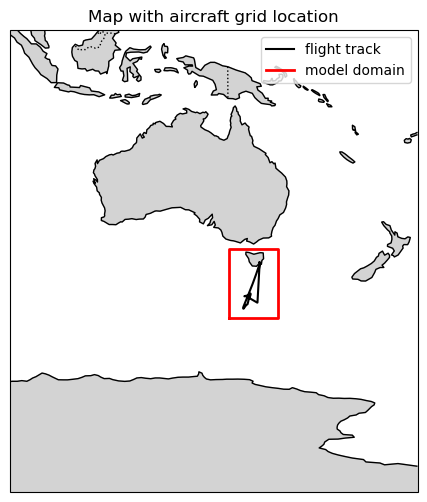

In [96]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming grid and bounds are already defined

grid, bounds = make_grid(cesm_fr, nc)

# Define the lat/lon boundaries of the square
lat_min, lat_max = float(cesm.lat[bounds['lat'][0]-1]), float(cesm.lat[bounds['lat'][1]+2])  # Latitude range
lon_min, lon_max = float(cesm.lon[bounds['lon'][0]-1]), float(cesm.lon[bounds['lon'][1]+2])  # Longitude range

# Create a plot with Cartopy's PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Add global map features
ax.add_feature(cfeature.LAND, edgecolor='black', color='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()
ax.coastlines()

# Plot the flight track with proper transformation
ax.plot(nc.LONC, nc.LATC, label='flight track', color='black', transform=ccrs.PlateCarree())

# Plot the square of coordinates
square_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
square_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
ax.plot(square_lons, square_lats, color='red', linewidth=2,label='model domain', transform=ccrs.PlateCarree())

# Set the extent to zoom in on the region around the square
buffer = 45  # Degrees to add around the square for some padding
# Ensure that the longitude wrapping is handled correctly
lon_min_zoom = max(lon_min - buffer, -180)
lon_max_zoom = min(lon_max + buffer, 180)

# Set the extent for zooming in on the region around the square
ax.set_extent([lon_min_zoom, lon_max_zoom, lat_min - buffer, lat_max + buffer], crs=ccrs.PlateCarree())

# Set title
ax.set_title('Map with aircraft grid location')
ax.legend()
# Show plot
plt.show()

In [134]:
def grid_flight_dat(cesm: xr.open_dataset, cesm_dat: xr.open_dataset, df: pd.DataFrame, air: xr.open_dataset) -> dict:    
    """
    Grids aircraft data and scales it onto a 3D grid.
    
    This function maps aircraft data onto a predefined grid based on CESM data,
    using the region defined by the bounds of the flight data.
    
    NOTE: A low-rate, 1 Hz, flight data file is assumed.
    
    :param gv_dat: A dataset object containing aircraft data (e.g., LATC, LONC, U, V, T).
    :param cesm_dat: A dataset object containing CESM data (e.g., lat, lon, lev).
    :param grid: A 3D numpy array representing the grid, typically created based on flight region.
    :param bounds: A dictionary containing the latitude, longitude, and altitude bounds for the grid.
    
    :return: A dictionary containing latitude (lats), longitude (lons), and pressure altitude (palts)
             for grid cells where data is present.
    """

    def make_grid(cesm: xr.open_dataset, air: xr.open_dataset) -> tuple[np.ndarray, dict[str, list[int]]]:
        """
        Create a grid restricted to the aircraft flight region based on CESM and flight data.
        """
        required_cesm_attributes = ['lat', 'lon', 'lev']
        required_gv_attributes = ['LATC', 'LONC', 'PSXC']
        
        for attr in required_cesm_attributes:
            if not hasattr(cesm, attr):
                raise ValueError(f"CESM data is missing required attribute: {attr}")

        for attr in required_gv_attributes:
            if not hasattr(air, attr):
                raise ValueError(f"Flight data is missing required attribute: {attr}")

        try:
            lat_upr_bnd = int(np.abs(cesm.lat - np.max(air.LATC)).argmin())
            lat_lwr_bnd = int(np.abs(cesm.lat - np.min(air.LATC)).argmin())
            lon_upr_bnd = int(np.abs(cesm.lon - np.max(air.LONC)).argmin())
            lon_lwr_bnd = int(np.abs(cesm.lon - np.min(air.LONC)).argmin())
            alt_upr_bnd = int(np.abs(cesm.lev - np.min(air.PSXC)).argmin())
            alt_lwr_bnd = int(np.abs(cesm.lev - np.max(air.PSXC)).argmin())
        except Exception as e:
            raise ValueError(f"Error calculating bounds: {e}")

        bounds = {
            'lat': [lat_lwr_bnd-1, lat_upr_bnd+1],
            'lon': [lon_lwr_bnd-1, lon_upr_bnd+1],
            'palt': [alt_upr_bnd-1, alt_lwr_bnd+1]
        }

        grid_shape = (
            (alt_lwr_bnd+1 - alt_upr_bnd+1), 
            (lat_upr_bnd+1 - lat_lwr_bnd+1), 
            (lon_upr_bnd+1 - lon_lwr_bnd+1)
        )
        grid = np.zeros(grid_shape, dtype=int)
        return grid, bounds
    
    grid, bounds = make_grid(cesm,nc)

    def filt_model_dims(cesm_dat: xr.open_dataset,df: pd.DataFrame):
        """
        Returns the lat, lon, and time from the nudged file that occur during specific research flight
        
        This function maps aircraft data onto a predefined grid based on CESM data
        
        NOTE: A low-rate, 1 Hz, flight data file is assumed.
        
        :param gv_dat: A dataset object containing aircraft data (e.g., LATC, LONC, U, V, T).
        :param cesm_dat: A dataset object containing CESM data (e.g., lat, lon, lev).
        
        :return: A dictionary containing latitude (lats), longitude (lons), and time 
                 for grid cells where data is present.
        """
        da = xr.DataArray(cesm_dat.time, dims="time")
        cesm_times = pd.to_datetime([pd.Timestamp(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
                            for dt in da.values])
        
        aircraft_times = df.Time
        
        matching_indices = cesm_times.isin(aircraft_times)
        # Assuming cesm_dat.lat and matching_indices are already defined
        # Create a boolean mask for lat values you want to exclude
        # lat = np.array(cesm_dat.lat[matching_indices])  # This gives the full lat array
        # lon = np.array(cesm_dat.lon[matching_indices])  # This gives the full lat array
        time = np.array(cesm_times[matching_indices])  # This gives the full lat array
        
        # # Define a threshold for what is considered a "high" difference
        # lat_threshold = 2  # You can adjust this value
        # lon_threshold = 2
        
        # # Find the indices where the difference exceeds the threshold
        # outlier_indices_lat = np.where(np.abs(np.diff(lat)) > lat_threshold)[0]
        # outlier_indices_lon = np.where(np.abs(np.diff(lon)) > lon_threshold)[0]
        
        # outliers = np.array([])
        
        # for i in range(0,len(outlier_indices_lat)-1):
        #     if lat[outlier_indices_lat[i+1]] < lat[outlier_indices_lat[i]]:
        #         outliers = np.append(outliers, int(outlier_indices_lat[i+1]))
        #     elif lat[outlier_indices_lat[i]] < lat[outlier_indices_lat[i+1]]:
        #         outliers = np.append(outliers, int(outlier_indices_lat[i]))
                
        # for i in range(0,len(outlier_indices_lon)-1):
        #     if lon[outlier_indices_lon[i+1]] < lon[outlier_indices_lon[i]]:
        #         outliers = np.append(outliers, int(outlier_indices_lon[i+1]))
        #     elif lon[outlier_indices_lon[i+1]] > lon[outlier_indices_lon[i]]:
        #         outliers = np.append(outliers, int(outlier_indices_lon[i]))
        # # print(outliers)      
        # # Create the exclude_mask, same length as lat, initially filled with False
        # exclude_mask = np.zeros_like(lat, dtype=bool)  # Shape matches lat
        
        # # # Set the outlier indices to True in the exclude_mask
        # exclude_mask[outliers.astype(int)] = True  # Mark outliers as True, which will exclude them
        
        # final_mask = ~exclude_mask
        
        # # check if there are any remaining outliers, usually at the beginning of the array where there's two consecutive outliers
        # lat_check = lat[final_mask]
        # outlier_indices_lat = np.where(np.abs(np.diff(lat_check)) > lat_threshold)[0]
        # if len(outlier_indices_lat) > 0:
        #     outliers = np.concatenate((outlier_indices_lat, outliers))
        #     # # Set the outlier indices to True in the exclude_mask
        #     exclude_mask[outliers.astype(int)] = True  # Mark outliers as True, which will exclude them
        
        #     final_mask = ~exclude_mask
        
        # filter_cesm_dims = {'lat': lat[final_mask],
        #                     'lon': lon[final_mask],
        #                     'time': time[final_mask]
        #                    }
        filter_nudg_time = {'time': time}
        # print(time)
        return filter_nudg_time

    filter_nudg_time = filt_model_dims(cesm_dat, df)

    mean_u = np.zeros_like(grid, dtype=float)
    mean_v = np.zeros_like(grid, dtype=float)
    mean_t = np.zeros_like(grid, dtype=float)
    mean_lat = np.zeros_like(grid, dtype=float)
    mean_lon = np.zeros_like(grid, dtype=float)
    mean_alt = np.zeros_like(grid, dtype=float)
        
    # Generate latitude, longitude, and altitude grid values
    lats = np.array(cesm.lat[bounds['lat'][0]:bounds['lat'][1]+1])
    lons = np.array(cesm.lon[bounds['lon'][0]:bounds['lon'][1]+1])
    alts = np.array(cesm.lev[bounds['palt'][0]:bounds['palt'][1]+1])
    alts = alts[::-1]
    times = filter_nudg_time['time']
    # Add 30 minutes
    new_time = times[-1] + np.timedelta64(30, 'm')
    minus_time = times[0] - np.timedelta64(30,'m')
    # Append new value
    times = np.append(times, new_time)
    times = np.append(minus_time, times)

    mid_time = []
    for t in range(0,len(times)-1):
    
        time_start, time_end = times[t], times[t+1]
        # Select aircraft data between time intervals
        air_time_indices = (df['Time'] > times[t]) & (df['Time'] <= times[t+1]) 
        sliced_df_time = df[air_time_indices]
    
        if not sliced_df_time.empty:
                # Digitize lat, lon, and alt into grid bins
                lat_bins = np.digitize(sliced_df_time['LATC'], lats) - 1
                lon_bins = np.digitize(sliced_df_time['LONC'], lons) - 1
                alt_bins = np.digitize(sliced_df_time['PSXC'], alts) - 1  # Reverse alt indexing
                # Ensure valid indices
                valid_mask = (lat_bins >= 0) & (lat_bins < len(lats) - 1) & \
                             (lon_bins >= 0) & (lon_bins < len(lons) - 1) & \
                             (alt_bins >= 0) & (alt_bins < len(alts) - 1)
            
                if valid_mask.any():
                    # Filter valid rows
                    sliced_df = sliced_df_time.loc[valid_mask].copy()
                    sliced_df['lat_bin'] = lat_bins[valid_mask]
                    sliced_df['lon_bin'] = lon_bins[valid_mask]
                    sliced_df['alt_bin'] = alt_bins[valid_mask]

                    # Group by grid cells and compute means                
                    grouped = sliced_df.groupby(['alt_bin', 'lat_bin', 'lon_bin'])

                    # print(grouped)
                    # print(grouped)
                    mean_u_vals = grouped['UIC'].mean()
                    mean_v_vals = grouped['VIC'].mean()
                    mean_t_vals = grouped['ATX'].mean()
                    mean_lat_vals = grouped['LATC'].mean()
                    mean_lon_vals = grouped['LONC'].mean()
                    mean_alt_vals = grouped['PSXC'].mean()
    
                    # Assign values to the grid
                    indices = tuple(zip(*mean_u_vals.index.to_numpy()))  # Unpack MultiIndex correctly
                    mean_u[indices] = mean_u_vals.values
                    mean_v[indices] = mean_v_vals.values
                    mean_t[indices] = mean_t_vals.values
                    mean_lat[indices] = mean_lat_vals.values
                    mean_lon[indices] = mean_lon_vals.values
                    mean_alt[indices] = mean_alt_vals.values
    
                    # Compute mid-time for each grid cell
                    grouped_times = grouped['Time'].agg(lambda x: x.min() + (x.max() - x.min()) / 2)
                    mid_time.extend(grouped_times.values)
    
        indices = np.argwhere(mean_t != 0)
        
        # Identify grid cells with non-zero data
        valid_indices = np.argwhere(mean_t != 0)
        alt_indices, lat_indices, lon_indices = valid_indices[:, 0], valid_indices[:, 1], valid_indices[:, 2]
    
        # # Calculate the center values of latitude, longitude, and altitude for each grid cell
        # selected_lats = (lats[lat_indices] + lats[lat_indices + 1]) / 2
        # selected_lons = (lons[lon_indices] + lons[lon_indices + 1]) / 2
        # selected_alts = (alts[alt_indices] + alts[alt_indices + 1]) / 2
        
        grid_dict = {'Time': mid_time,
                     'lats': mean_lat[mean_t !=0],
                     'lons': mean_lon[mean_t !=0],
                     'palts': mean_alt[mean_t !=0],
                     'mean_u': mean_u[mean_t !=0],
                     'mean_v': mean_v[mean_t !=0],
                     'mean_t': mean_t[mean_t !=0],
                    }
        
    return grid_dict

In [135]:
grid_data = grid_flight_dat(cesm_fr, cesm_ndg, df, nc)
# grid_data

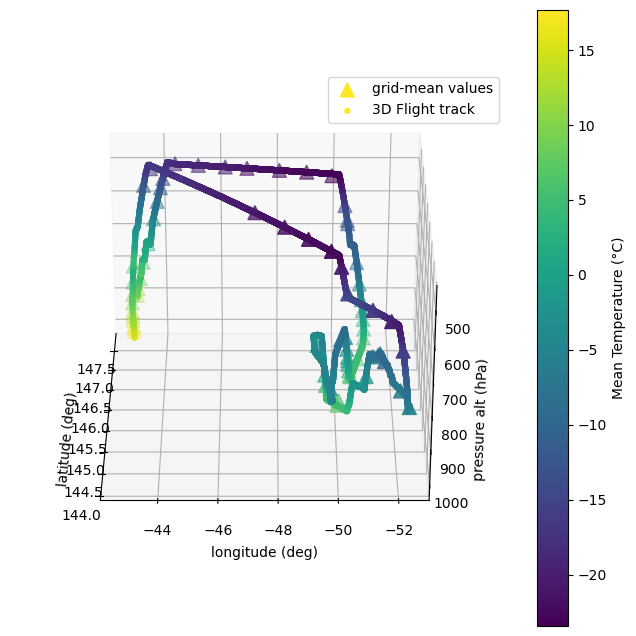

In [136]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation  

grid_data = grid_flight_dat(cesm_fr, cesm_ndg, df, nc)
# grid_data = grid_dict
# Create a figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(grid_data['lons'], grid_data['lats'], grid_data['palts'], c=grid_data['mean_t'], cmap='viridis', marker='^',label='grid-mean values',s=100)
# Invert the Z-axis
ax.scatter(nc.LONC, nc.LATC, nc.PSXC, c=nc.ATX, label='3D Flight track',s=12)
ax.invert_zaxis()

ax.set_xlabel('latitude (deg)')
ax.set_ylabel('longitude (deg)')
ax.set_zlabel('pressure alt (hPa)') 

ax.legend()
# # Color bar to show the mapping of color to the fourth dimension
plt.colorbar(sc, label='Mean Temperature (°C)')

# Animation function to rotate the view
def rotate(angle):
    ax.view_init(elev=30, azim=angle)

# Create animation
ani = FuncAnimation(fig, rotate, frames=np.arange(-180, 360, 20), interval=100)

# Show the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())
# Labels


# # Show the plot
# plt.show()